In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [2]:
def file_reader(basedir, filename):
    if filename.endswith('.csv'):
        try:
            df = pd.read_csv(basedir + filename, header=15)
        except:
            df = pd.read_csv(basedir + filename, encoding='euc-kr', header=15)
    elif filename.endswith('.xlsx'):
        try:
            df = pd.read_excel(basedir + filename, header=16)
        except:
            df = pd.read_excel(basedir + filename, encoding='euc-kr', header=16)
    else:
        print('error')
    
    return df

In [3]:
def read_data():
    basedir = './국토교통부_실거래가_공개시스템/'
    filenames = os.listdir(basedir)
    
    apart_trade_files = [filename for filename in filenames if filename.startswith('아파트(매매)')]
    apart_lease_files = [filename for filename in filenames if filename.startswith('아파트(전월세)')]
    multiplex_trade_files = [filename for filename in filenames if filename.startswith('연립다세대(매매)')]
    multiplex_lease_files = [filename for filename in filenames if filename.startswith('연립다세대(전월세)')]
    officetel_trade_files = [filename for filename in filenames if filename.startswith('오피스텔(매매)')]
    officetel_lease_files = [filename for filename in filenames if filename.startswith('오피스텔(전월세)')]
    
    #
    apart_trade_dfs_list = []
    for filename in apart_trade_files:
        df = file_reader(basedir, filename)
        apart_trade_dfs_list.append(df)
    apart_trade_df = pd.concat(apart_trade_dfs_list).reset_index(drop=True)
    
    #
    apart_lease_dfs_list = []
    for filename in apart_lease_files:
        df = file_reader(basedir, filename)
        apart_lease_dfs_list.append(df)
    apart_lease_df = pd.concat(apart_lease_dfs_list).reset_index(drop=True)
    
    #
    multiplex_trade_dfs_list = []
    for filename in multiplex_trade_files:
        df = file_reader(basedir, filename)
        multiplex_trade_dfs_list.append(df)
    multiplex_trade_df = pd.concat(multiplex_trade_dfs_list).reset_index(drop=True)
    
    #
    multiplex_lease_dfs_list = []
    for filename in multiplex_lease_files:
        df = file_reader(basedir, filename)
        multiplex_lease_dfs_list.append(df)
    multiplex_lease_df = pd.concat(multiplex_lease_dfs_list).reset_index(drop=True)
    
    #
    officetel_trade_dfs_list = []
    for filename in officetel_trade_files:
        df = file_reader(basedir, filename)
        officetel_trade_dfs_list.append(df)
    officetel_trade_df = pd.concat(officetel_trade_dfs_list).reset_index(drop=True)
    
    #
    officetel_lease_dfs_list = []
    for filename in officetel_lease_files:
        df = file_reader(basedir, filename)
        officetel_lease_dfs_list.append(df)
    officetel_lease_df = pd.concat(officetel_lease_dfs_list).reset_index(drop=True)
    
    
    return apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df

In [5]:
%%time
apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df\
= read_data()

C:\Users\나\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  if __name__ == '__main__':
C:\Users\나\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 4min 50s


# From previous EDA and Preprocessing

In [6]:
apart_lease_df.drop(apart_lease_df[apart_lease_df['전용면적(㎡)'].isna()].index, inplace=True)

In [7]:
multiplex_trade_df.loc[multiplex_trade_df[multiplex_trade_df['건축년도'].isna()].index, '건축년도'] = 1971
multiplex_lease_df.drop(multiplex_lease_df[multiplex_lease_df['층'].isna()].index, inplace=True)

In [8]:
# 모든 df 도로명 빈 칸 null 로 교체

def replace_empty_to_null(df):
    df = df.copy()
    
    empty_df = df[df['도로명'] == ' ']
    
    df.loc[empty_df.index, '도로명'] = np.nan
    
    return df

In [9]:
apart_trade_df = replace_empty_to_null(apart_trade_df)
apart_lease_df = replace_empty_to_null(apart_lease_df)
multiplex_trade_df = replace_empty_to_null(multiplex_trade_df)
multiplex_lease_df = replace_empty_to_null(multiplex_lease_df)
officetel_trade_df = replace_empty_to_null(officetel_trade_df)
officetel_lease_df = replace_empty_to_null(officetel_lease_df)

In [10]:
multiplex_lease_df.loc[multiplex_lease_df[multiplex_lease_df['건축년도'].isna()].index, '건축년도'] = 1971

In [11]:
# 건축년도가 null 인 row 들에 있는 주소들 중에서, 같은 주소지만 건축년도 값이 있는 주소는 null 을 채워넣고, 없는 주소는 df 에서 제거.
# 추가적으로, 한 주소지, 단지이름에 건축년도가 두 가지 이상 있는지도 조사함.

def bltyear_fill_and_remove_null(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'] + df['번지'] + df['단지명']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    unique_addrs = bltyear_null_df['temp_full_addr'].unique()
    
    concat_list = []
    for addr in unique_addrs:
        addr_df = df[df['temp_full_addr'] == addr]
        if addr_df['건축년도'].isna().sum() != addr_df.shape[0]:
            if addr_df['건축년도'].std() != 0:
                print('건축년도가 두 가지 이상인 주소가 있음.')
            
            addr_df['건축년도'].fillna(addr_df['건축년도'].mean(), inplace=True)
            
            concat_list.append(addr_df)
    
    df.drop(columns=['temp_full_addr'], inplace=True)
    
    if len(concat_list) > 0:
        concat_df = pd.concat(concat_list)
    else:
        return df
    
    #return concat_df
    
    df.loc[concat_df.index, '건축년도'] = concat_df['건축년도']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    df.drop(bltyear_null_df.index, inplace=True)
        
    return df.reset_index(drop=True)

In [12]:
officetel_trade_df = bltyear_fill_and_remove_null(officetel_trade_df)
officetel_lease_df = bltyear_fill_and_remove_null(officetel_lease_df)

In [13]:
def trade_dfs_change_dtype(df):
    df = df.copy()
    
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(str)
    df['거래금액(만원)'] = pd.to_numeric(df['거래금액(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [14]:
apart_trade_df = trade_dfs_change_dtype(apart_trade_df)
multiplex_trade_df = trade_dfs_change_dtype(multiplex_trade_df)
officetel_trade_df = trade_dfs_change_dtype(officetel_trade_df)

In [15]:
def lease_dfs_change_dtype(df):
    df = df.copy()
    
    df['보증금(만원)'] = df['보증금(만원)'].apply(str)
    df['월세(만원)'] = df['월세(만원)'].apply(str)
    df['보증금(만원)'] = pd.to_numeric(df['보증금(만원)'].str.replace(',', ''))
    df['월세(만원)'] = pd.to_numeric(df['월세(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [16]:
apart_lease_df = lease_dfs_change_dtype(apart_lease_df)
multiplex_lease_df = lease_dfs_change_dtype(multiplex_lease_df)
officetel_lease_df = lease_dfs_change_dtype(officetel_lease_df)

In [17]:
def price_per_area_and_year_month(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    elif mode == 'lease':
        df['가격/면적'] = df['보증금(만원)'] / df['전용면적(㎡)']
    
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    df['month'] = pd.to_numeric(df['계약년월'].astype('str').str[4:])
    
    return df   

In [18]:
apart_trade_df = price_per_area_and_year_month(apart_trade_df)
multiplex_trade_df = price_per_area_and_year_month(multiplex_trade_df)
officetel_trade_df = price_per_area_and_year_month(officetel_trade_df)

In [19]:
apart_lease_df = price_per_area_and_year_month(apart_lease_df, mode='lease')
multiplex_lease_df = price_per_area_and_year_month(multiplex_lease_df, mode='lease')
officetel_lease_df = price_per_area_and_year_month(officetel_lease_df, mode='lease')

In [20]:
def si_gu(df):
    df = df.copy()
    
    df['시'] = df['시군구'].str.split(' ').apply(lambda x: x[0])
    df['구'] = df['시군구'].str.split(' ').apply(lambda x: x[1])
    
    return df

In [21]:
apart_trade_df = si_gu(apart_trade_df)
apart_lease_df = si_gu(apart_lease_df)
multiplex_trade_df = si_gu(multiplex_trade_df)
multiplex_lease_df = si_gu(multiplex_lease_df)
officetel_trade_df = si_gu(officetel_trade_df)
officetel_lease_df = si_gu(officetel_lease_df)

In [26]:
apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
multiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
multiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
officetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
officetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)

# EDA & Preprocessing 8

In [27]:
apart_trade_df['거래금액(만원)'].describe()

count    1.168192e+06
mean     5.231642e+04
std      4.018041e+04
min      3.500000e+02
25%      2.800000e+04
50%      4.130000e+04
75%      6.300000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

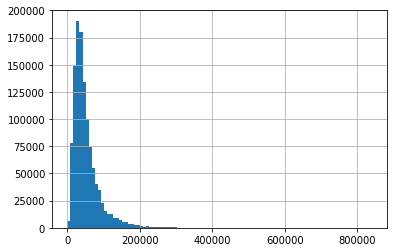

In [32]:
apart_trade_df['거래금액(만원)'].hist(bins=100)

<AxesSubplot:>

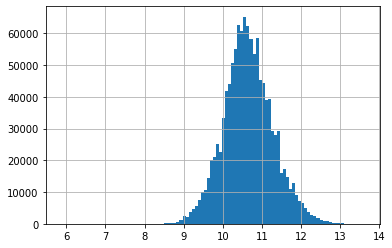

In [31]:
apart_trade_df['거래금액(만원)'].apply(lambda x: np.log(x)).hist(bins=100)

In [39]:
def show_original_and_log_hist(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        display(df['거래금액(만원)'].hist(bins=100))
        plt.show()
        plt.clf()
        display(df['거래금액(만원)'].apply(lambda x: np.log(x)).hist(bins=100))
        plt.show()
        plt.clf()
    elif mode == 'lease':
        display(df['보증금(만원)'].hist(bins=100))
        plt.show()
        plt.clf()
        display(df['보증금(만원)'].apply(lambda x: np.log(x)).hist(bins=100))
        plt.show()
        plt.clf()

<AxesSubplot:>

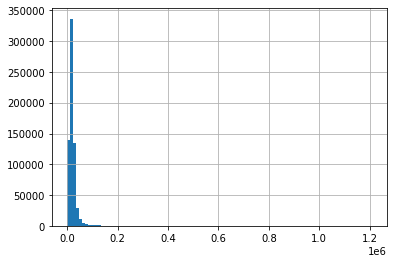

<AxesSubplot:>

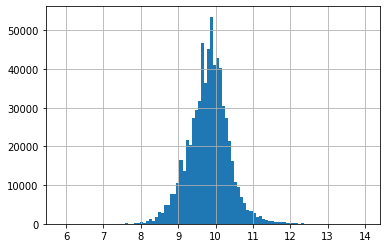

<Figure size 432x288 with 0 Axes>

In [40]:
show_original_and_log_hist(multiplex_trade_df)

<AxesSubplot:>

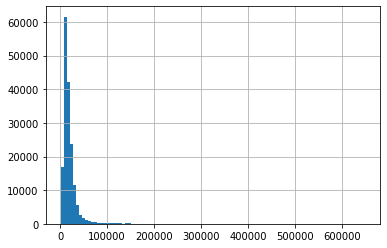

<AxesSubplot:>

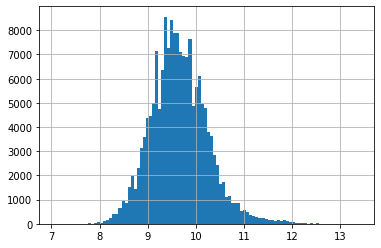

<Figure size 432x288 with 0 Axes>

In [41]:
show_original_and_log_hist(officetel_trade_df)

<AxesSubplot:>

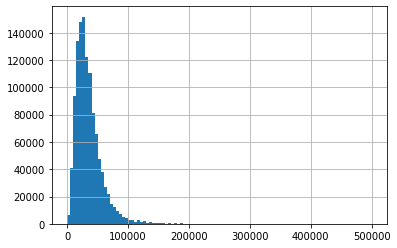

<AxesSubplot:>

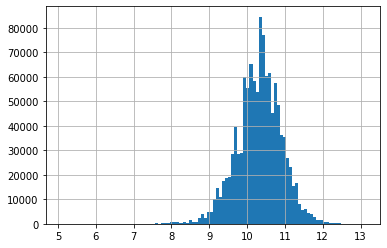

<Figure size 432x288 with 0 Axes>

In [45]:
show_original_and_log_hist(apart_lease_deposit_only_df, mode='lease')

<AxesSubplot:>

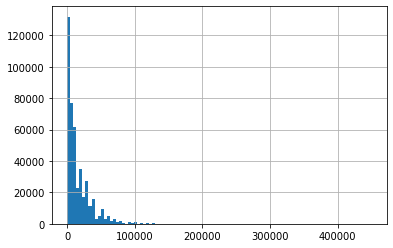

ValueError: supplied range of [-inf, 13.017002861746503] is not finite

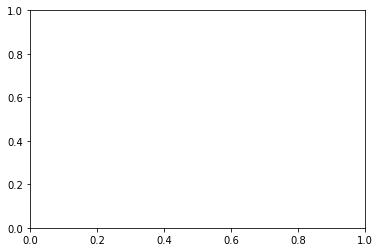

In [47]:
show_original_and_log_hist(apart_lease_monthly_pay_df, mode='lease')

In [52]:
apart_lease_monthly_pay_df['지번주소'] = apart_lease_monthly_pay_df['시군구'] + apart_lease_monthly_pay_df['번지']

In [53]:
zero_df = apart_lease_monthly_pay_df[apart_lease_monthly_pay_df['보증금(만원)'] == 0]
zero_df.shape

(266, 20)

In [54]:
zero_df

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,지번주소
265,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,50.6700,201101,12,0,60,1,1982,삼성로 14,0.0,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
1389,서울특별시 강남구 대치동,511,511,0,한보미도맨션1,월세,128.0100,201106,3,0,380,11,1983,남부순환로 3032,0.0,2011,6,서울특별시,강남구,서울특별시 강남구 대치동511
2391,서울특별시 강남구 신사동,606-2,606,2,신사 아크존2,월세,135.7200,201106,11,0,30,3,2005,압구정로34길 49,0.0,2011,6,서울특별시,강남구,서울특별시 강남구 신사동606-2
2421,서울특별시 강남구 압구정동,397,397,0,미성2차,월세,140.9000,201107,30,0,350,4,1987,압구정로 113,0.0,2011,7,서울특별시,강남구,서울특별시 강남구 압구정동397
2429,서울특별시 강남구 압구정동,433,433,0,신현대11차,월세,115.2300,201105,20,0,210,1,1983,압구정로 151,0.0,2011,5,서울특별시,강남구,서울특별시 강남구 압구정동433
2780,서울특별시 강남구 역삼동,633,633,0,베스젠빌,월세,139.2300,201108,23,0,420,1,2003,논현로97길 74,0.0,2011,8,서울특별시,강남구,서울특별시 강남구 역삼동633
3708,서울특별시 강동구 강일동,707,707,0,고덕리엔파크1단지,월세,84.8300,201102,28,0,15,2,2011,상일로 152,0.0,2011,2,서울특별시,강동구,서울특별시 강동구 강일동707
3824,서울특별시 강동구 고덕동,492,492,0,고덕시영,월세,49.1350,201109,6,0,40,1,1984,아리수로50길 82,0.0,2011,9,서울특별시,강동구,서울특별시 강동구 고덕동492
3962,서울특별시 강동구 길동,400,400,0,길동우성,월세,84.7500,201107,28,0,150,5,1994,천호대로193길 37,0.0,2011,7,서울특별시,강동구,서울특별시 강동구 길동400
6152,서울특별시 강서구 등촌동,707,707,0,"등촌7,8단지주공아파트",월세,41.8500,201107,10,0,65,7,1994,공항대로43길 104,0.0,2011,7,서울특별시,강서구,서울특별시 강서구 등촌동707


In [55]:
zero_first_addr_df = apart_lease_monthly_pay_df[apart_lease_monthly_pay_df['지번주소'] == zero_df['지번주소'].iloc[0]]
zero_first_addr_df.shape

(940, 20)

In [56]:
zero_first_addr_df.head(50)

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,지번주소
260,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,42.55,201101,5,2000,60,3,1982,삼성로 14,47.003525,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
261,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,41.99,201101,6,4000,40,5,1982,삼성로 14,95.260776,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
262,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,35.87,201101,8,1000,50,3,1982,삼성로 14,27.878450,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
263,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,50.39,201101,12,4000,50,5,1982,삼성로 14,79.380830,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
264,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,42.55,201101,12,4000,35,4,1982,삼성로 14,94.007051,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
265,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,50.67,201101,12,0,60,1,1982,삼성로 14,0.000000,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
266,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,35.87,201101,15,1000,50,1,1982,삼성로 14,27.878450,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
267,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,50.67,201101,19,2000,80,3,1982,삼성로 14,39.471087,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
268,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,35.64,201101,22,3000,25,5,1982,삼성로 14,84.175084,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189
269,서울특별시 강남구 개포동,189,189,0,개포주공 4단지,월세,41.99,201101,25,1000,55,4,1982,삼성로 14,23.815194,2011,1,서울특별시,강남구,서울특별시 강남구 개포동189


In [57]:
# 보증금 0인 이유 유추 불가. 없애기로 함.

In [58]:
def remove_zero_deposit(df):
    df = df.copy()
    
    df = df[df['보증금(만원)'] != 0].reset_index(drop=True)
    
    return df

In [59]:
apart_lease_monthly_pay_df = remove_zero_deposit(apart_lease_monthly_pay_df)
multiplex_lease_monthly_pay_df = remove_zero_deposit(multiplex_lease_monthly_pay_df)
officetel_lease_monthly_pay_df = remove_zero_deposit(officetel_lease_monthly_pay_df)

In [79]:
apart_lease_deposit_only_df['보증금(만원)'].describe()

count    1.160500e+06
mean     3.582416e+04
std      2.236043e+04
min      1.600000e+02
25%      2.100000e+04
50%      3.100000e+04
75%      4.500000e+04
max      5.000000e+05
Name: 보증금(만원), dtype: float64

In [80]:
multiplex_lease_deposit_only_df['보증금(만원)'].describe()

count    530928.000000
mean      16808.094518
std        8737.895119
min         174.000000
25%       11000.000000
50%       15500.000000
75%       21000.000000
max      400000.000000
Name: 보증금(만원), dtype: float64

In [81]:
officetel_lease_deposit_only_df['보증금(만원)'].describe()

count    125221.000000
mean      17340.473371
std       10366.035430
min         100.000000
25%       11000.000000
50%       15000.000000
75%       21000.000000
max      215000.000000
Name: 보증금(만원), dtype: float64

<AxesSubplot:>

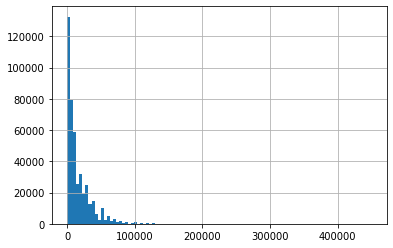

<AxesSubplot:>

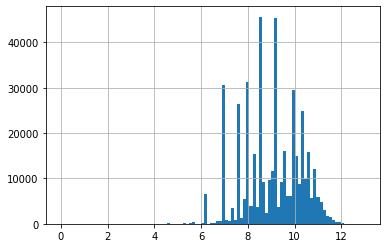

<Figure size 432x288 with 0 Axes>

In [60]:
show_original_and_log_hist(apart_lease_monthly_pay_df, mode='lease')

In [61]:
apart_lease_monthly_pay_df.shape

(438624, 20)

<AxesSubplot:ylabel='Density'>

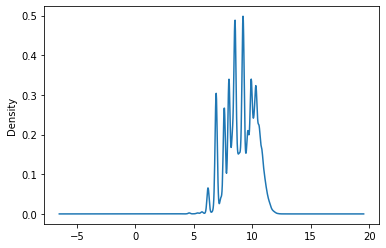

In [64]:
apart_lease_monthly_pay_df['보증금(만원)'].apply(lambda x: np.log(x)).plot.density()

In [75]:
apart_lease_monthly_pay_df['보증금(만원)'].describe()

count    438624.000000
mean      16167.511484
std       18995.733008
min           1.000000
25%        3036.000000
50%       10000.000000
75%       23000.000000
max      450000.000000
Name: 보증금(만원), dtype: float64

In [76]:
apart_lease_monthly_pay_df.head(20)

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,지번주소
0,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201103,18,19000,63,1,1987,언주로 3,237.589096,2011,3,서울특별시,강남구,서울특별시 강남구 개포동658-1
1,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201104,9,21000,35,1,1987,언주로 3,262.598474,2011,4,서울특별시,강남구,서울특별시 강남구 개포동658-1
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201107,9,3000,160,4,1987,언주로 3,37.514068,2011,7,서울특별시,강남구,서울특별시 강남구 개포동658-1
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201109,19,6000,140,1,1987,언주로 3,75.028136,2011,9,서울특별시,강남구,서울특별시 강남구 개포동658-1
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201109,20,5000,160,2,1987,언주로 3,62.523446,2011,9,서울특별시,강남구,서울특별시 강남구 개포동658-1
5,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,54.98,201110,25,10000,70,1,1987,언주로 3,181.884322,2011,10,서울특별시,강남구,서울특별시 강남구 개포동658-1
6,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,67.28,201110,30,19000,20,1,1987,언주로 3,282.401902,2011,10,서울특별시,강남구,서울특별시 강남구 개포동658-1
7,서울특별시 강남구 개포동,652,652,0,개포우성3차,월세,104.43,201105,26,10000,120,7,1984,개포로 307,95.757924,2011,5,서울특별시,강남구,서울특별시 강남구 개포동652
8,서울특별시 강남구 개포동,652,652,0,개포우성3차,월세,133.46,201111,9,35000,110,7,1984,개포로 307,262.250862,2011,11,서울특별시,강남구,서울특별시 강남구 개포동652
9,서울특별시 강남구 개포동,12-2,12,2,개포자이(12-2),월세,168.42,201104,16,60000,70,18,2004,개포로109길 69,356.252227,2011,4,서울특별시,강남구,서울특별시 강남구 개포동12-2


<AxesSubplot:>

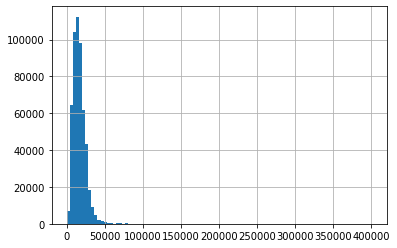

<AxesSubplot:>

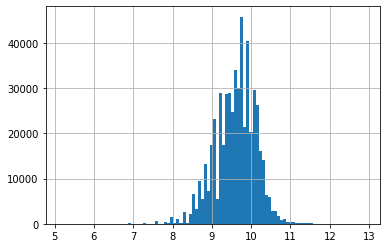

<Figure size 432x288 with 0 Axes>

In [65]:
show_original_and_log_hist(multiplex_lease_deposit_only_df, mode='lease')

<AxesSubplot:>

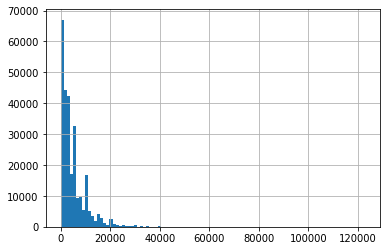

<AxesSubplot:>

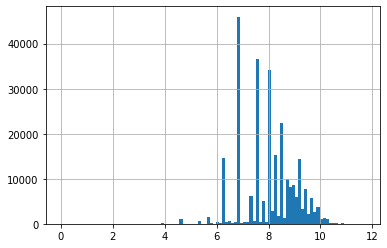

<Figure size 432x288 with 0 Axes>

In [66]:
show_original_and_log_hist(multiplex_lease_monthly_pay_df, mode='lease')

<AxesSubplot:>

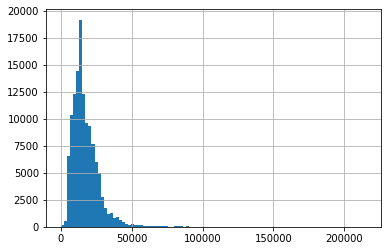

<AxesSubplot:>

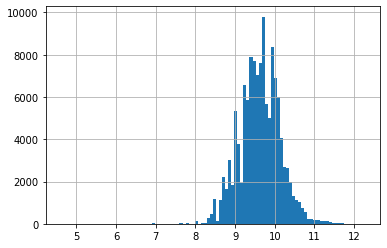

<Figure size 432x288 with 0 Axes>

In [67]:
show_original_and_log_hist(officetel_lease_deposit_only_df, mode='lease')

<AxesSubplot:>

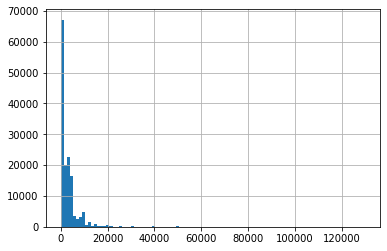

<AxesSubplot:>

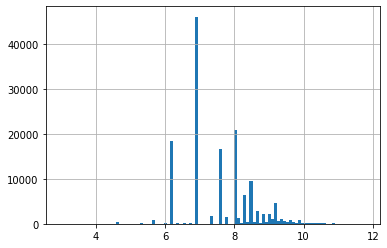

<Figure size 432x288 with 0 Axes>

In [68]:
show_original_and_log_hist(officetel_lease_monthly_pay_df, mode='lease')

In [74]:
officetel_lease_monthly_pay_df.shape

(146865, 19)

In [78]:
officetel_lease_monthly_pay_df['보증금(만원)'].describe()

count    146865.000000
mean       3321.675246
std        5086.004874
min          20.000000
25%        1000.000000
50%        2000.000000
75%        4000.000000
max      130000.000000
Name: 보증금(만원), dtype: float64

In [89]:
apart_lease_monthly_pay_df['월세(만원)'].describe()

count    438624.000000
mean         78.787203
std          65.254165
min           0.000000
25%          40.000000
50%          60.000000
75%         100.000000
max        2030.000000
Name: 월세(만원), dtype: float64

<AxesSubplot:>

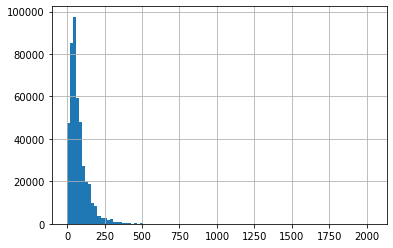

In [90]:
apart_lease_monthly_pay_df['월세(만원)'].hist(bins=100)

In [92]:
zero_df = apart_lease_monthly_pay_df[apart_lease_monthly_pay_df['월세(만원)'] == 0]
zero_df.shape

(64, 20)

In [93]:
zero_df

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,지번주소
540,서울특별시 강남구 개포동,12,12,0,성원대치2단지아파트,월세,33.1800,201104,2,10000,0,14,1992,개포로109길 9,301.386377,2011,4,서울특별시,강남구,서울특별시 강남구 개포동12
871,서울특별시 강남구 논현동,258,258,0,두산위브2단지,월세,84.2530,201107,20,10000,0,6,2004,언주로122길 25,118.690136,2011,7,서울특별시,강남구,서울특별시 강남구 논현동258
7440,서울특별시 관악구 신림동,1735,1735,0,관악산휴먼시아 2단지,월세,84.9800,201103,4,6000,0,15,2008,난곡로 55,70.604848,2011,3,서울특별시,관악구,서울특별시 관악구 신림동1735
8465,서울특별시 구로구 구로동,794-24,794,24,(794-24),월세,53.5600,201103,14,8100,0,4,1995,디지털로27길 124-30,151.232263,2011,3,서울특별시,구로구,서울특별시 구로구 구로동794-24
15402,서울특별시 마포구 도화동,550,550,0,삼성,월세,72.1850,201102,24,3000,0,13,1997,도화길 28,41.559881,2011,2,서울특별시,마포구,서울특별시 마포구 도화동550
23208,서울특별시 송파구 풍납동,388-7,388,7,우성,월세,51.2000,201101,29,14000,0,12,1984,올림픽로43길 30,273.437500,2011,1,서울특별시,송파구,서울특별시 송파구 풍납동388-7
27647,서울특별시 중랑구 중화동,450,450,0,한신1차,월세,59.7600,201104,23,5000,0,18,1997,동일로 752,83.668005,2011,4,서울특별시,중랑구,서울특별시 중랑구 중화동450
27661,서울특별시 강남구 개포동,652,652,0,개포우성3차,월세,104.4300,201201,7,35000,0,4,1984,개포로 307,335.152734,2012,1,서울특별시,강남구,서울특별시 강남구 개포동652
38484,서울특별시 노원구 상계동,670,670,0,상계주공9(고층),월세,45.9000,201208,20,9000,0,6,1988,노원로 532,196.078431,2012,8,서울특별시,노원구,서울특별시 노원구 상계동670
38572,서울특별시 노원구 상계동,1312,1312,0,수락리버시티3단지,월세,49.9300,201211,23,7935,0,12,2009,누원로 28,158.922491,2012,11,서울특별시,노원구,서울특별시 노원구 상계동1312


In [95]:
apart_lease_deposit_only_df['지번주소'] = apart_lease_deposit_only_df['시군구'] + apart_lease_deposit_only_df['번지']

In [96]:
zero_addr_df = apart_lease_deposit_only_df[apart_lease_deposit_only_df['지번주소'] == zero_df['지번주소'].iloc[0]]
zero_addr_df.shape

(3962, 20)

In [98]:
zero_addr_df.head(200)

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,지번주소
2000,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,51.12,201101,4,21000,0,1,1992,개포로109길 21,410.798122,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2001,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,51.12,201101,4,22000,0,2,1992,개포로109길 21,430.359937,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2002,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,60.00,201101,7,24000,0,3,1992,개포로109길 21,400.000000,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2003,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,51.12,201101,10,21000,0,2,1992,개포로109길 21,410.798122,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2004,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,60.00,201101,11,25000,0,13,1992,개포로109길 21,416.666667,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2005,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,51.12,201101,13,22000,0,4,1992,개포로109길 21,430.359937,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2006,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,39.53,201101,15,18000,0,5,1992,개포로109길 21,455.350367,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2007,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,39.53,201101,15,18000,0,12,1992,개포로109길 21,455.350367,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2008,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,60.00,201101,20,25500,0,6,1992,개포로109길 21,425.000000,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12
2009,서울특별시 강남구 개포동,12,12,0,삼익대청아파트,전세,60.00,201101,21,24000,0,12,1992,개포로109길 21,400.000000,2011,1,서울특별시,강남구,서울특별시 강남구 개포동12


In [100]:
def remove_zero(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df = df[df['거래금액(만원)'] != 0].reset_index(drop=True)
    elif mode == 'lease':
        df = df[df['보증금(만원)'] != 0].reset_index(drop=True)
    
    return df

In [101]:
apart_trade_df = remove_zero(apart_trade_df)
apart_lease_df = remove_zero(apart_lease_df, mode='lease')
multiplex_trade_df = remove_zero(multiplex_trade_df)
multiplex_lease_df = remove_zero(multiplex_lease_df, mode='lease')
officetel_trade_df = remove_zero(officetel_trade_df)
officetel_lease_df = remove_zero(officetel_lease_df, mode='lease')

In [104]:
def correct_lease_type(df):
    df = df.copy()
    
    wrong_df = df[(df['전월세구분'] == '월세') & (df['월세(만원)'] == 0)]
    
    df.loc[wrong_df.index, '전월세구분'] = '전세'
    
    return df

In [105]:
apart_lease_df = correct_lease_type(apart_lease_df)
multiplex_lease_df = correct_lease_type(multiplex_lease_df)
officetel_lease_df = correct_lease_type(officetel_lease_df)

In [106]:
dfs_list = [apart_lease_df, multiplex_lease_df, officetel_lease_df]
for df in dfs_list:
    zero_df = df[(df['전월세구분'] == '월세') & (df['월세(만원)'] == 0)]
    print(zero_df.shape)

(0, 19)
(0, 19)
(0, 19)
